[-0.41796875, -0.0859375, 0.0]


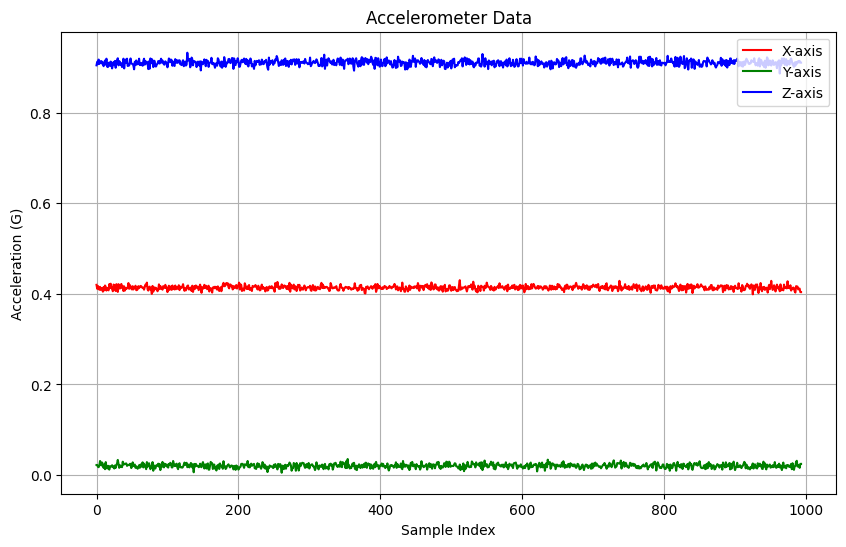

In [81]:
import json
import matplotlib.pyplot as plt
import numpy as np

def bit_to_offset(bit_offset, step = 1/256):
    offset = [] 
    for v in bit_offset:
        offset.append(v*step)
    return offset

# Load the JSON file
with open(r'Data\Events\Event - 5\KA62db91c0d535cb1f5e4cc889.json', 'r') as file:
    data = json.load(file)

offset = bit_to_offset(data.get("Offset",[0,0,0]))
print(offset)
# Extract accelerometer data
raw_data = data.get("RawData", {})
acc_x = np.array(raw_data.get("Acc_X", {}).get("Data", [])) - offset[0]
acc_y = np.array(raw_data.get("Acc_Y", {}).get("Data", [])) - offset[1]
acc_z = np.array(raw_data.get("Acc_Z", {}).get("Data", [])) - offset[2]

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(acc_x, label='X-axis', color='red')
plt.plot(acc_y, label='Y-axis', color='green')
plt.plot(acc_z, label='Z-axis', color='blue')

# Add labels and legend
plt.title("Accelerometer Data")
plt.xlabel("Sample Index")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [82]:
import sys
import os
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath(os.path.join(".", os.pardir)))
sys.path.append(os.path.join(".", 'Packages'))

from OnWindshield import OnWS

onWindshield_history = [
    {
        "WSRange": {
            "x_range": [-15,20],
            "y_range": [5,65]
        }}]
calibration_history = [
    {
        "OperationalAngles": [0,127,180],
        "Status": "init"
    }]

# data to df

rawData_df = pd.DataFrame(np.array([acc_x,acc_y,acc_z]).T, columns=["Acc_X","Acc_Y","Acc_Z"])


onWindshieldObj = OnWS(".", rawData_df, 1, onWindshield_history, calibration_history, "KA", [0,0,0])
onWindshieldResult = onWindshieldObj.run()

00:31:51 :  OnWS: module initialize
00:31:51 :  OnWS: Offset [0, 0, 0] was substracted from signal
00:31:51 :  OnWS: Orientation is: ALIGNED ,Init condition for torch search: [0, 127, 180]
00:31:52 :  OnWS: Angles found are: [-0.13467910885810852, 24.412330627441406, 177.5949249267578]
00:31:52 :  OnWS: Decision is On WS, ReasonDesc: Angles match WS and button is pressed


In [83]:
onWindshieldResult

{'Decision': True,
 'Reason': 'Normal angles',
 'ReasonDesc': 'Angles match WS and button is pressed',
 'ButtonPressed': {'Decision': True, 'Reason': 'Sample is on'},
 'WSRange': {'x_range': [-15, 20], 'y_range': [5, 65]},
 'A0': [0.41353515625, 0.0194970703125, 0.9107470703125],
 'InitCond': [0, 127, 180],
 'Angles': [-0.13467910885810852, 24.412330627441406, 177.5949249267578],
 'WSRef': 127,
 'Orientation': 'aligned',
 'ManualOrientation': None,
 'EstWSAngles': None,
 'ResetCalibrationHistory': None,
 'ResetOffset': False}

In [84]:
def calc_rotmat(angles):
    """
    calc rotation matrix by 'Y','X','Z' from https://www.geometrictools.com/Documentation/EulerAngles.pdf
    But, the order of moving is 'Z','X','Y'
    """
    cos = lambda x: np.cos(np.deg2rad(x))
    sin = lambda x: np.sin(np.deg2rad(x))

    phi_x, theta_y, psi_z = angles
    rotmat = np.array(
        [[cos(theta_y)*cos(psi_z)+sin(phi_x)*sin(theta_y)*sin(psi_z), -1*cos(theta_y)*sin(psi_z)+cos(psi_z)*sin(phi_x)*sin(theta_y),  cos(phi_x)*sin(theta_y)  ],
        [cos(phi_x)*sin(psi_z)                                      ,  cos(phi_x)*cos(psi_z)                                       , -1*sin(phi_x)             ],
        [cos(theta_y)*sin(phi_x)*sin(psi_z)-cos(psi_z)*sin(theta_y) ,  cos(theta_y)*cos(psi_z)*sin(phi_x)+sin(theta_y)*sin(psi_z)  ,  cos(phi_x)*cos(theta_y)]])
    return rotmat

In [85]:
OperationalMat = calc_rotmat(onWindshieldResult["Angles"])
OperationalMat

array([[-0.90983338, -0.03724169,  0.41329927],
       [ 0.04196404, -0.99911636,  0.00235059],
       [ 0.41284652,  0.01948235,  0.91059222]])

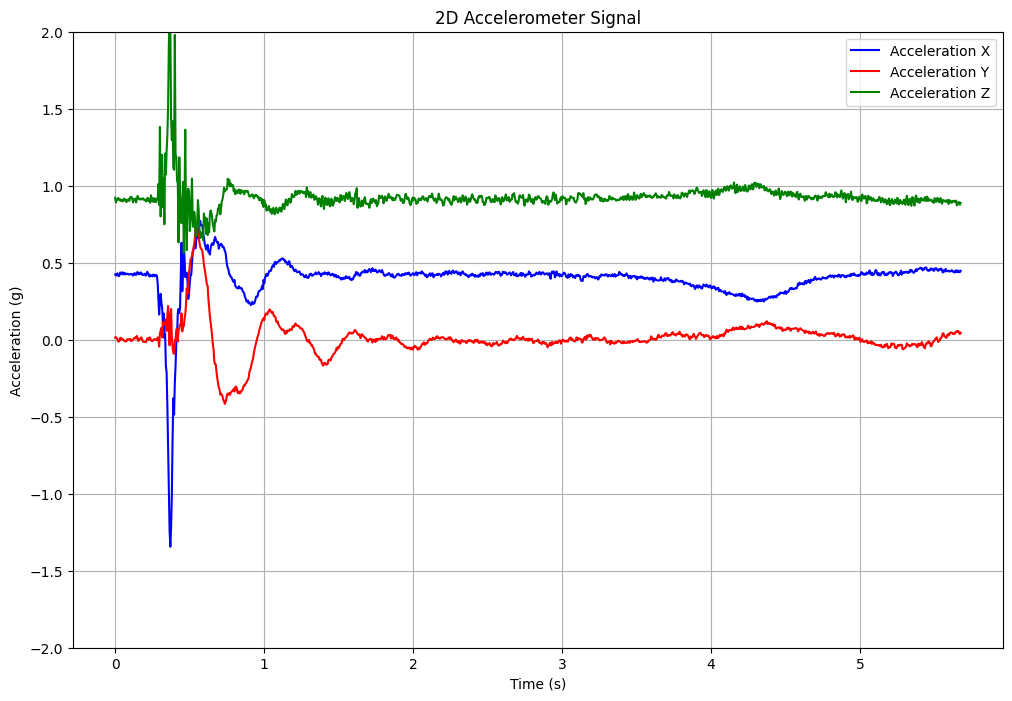

In [86]:
# Load JSON data
with open(r'Data\Events\Event - 5\EV62e5f7c7214dc35247117289.json', 'r') as f:
    data = json.load(f)

# Extract accelerometer data and time
acc_x = np.array(data['Acc_X']['Data']) - offset[0]
acc_y = np.array(data['Acc_Y']['Data']) - offset[1]
acc_z = np.array(data['Acc_Z']['Data']) - offset[2]

total_time = data['TotalTimeRecorded']
num_samples = len(acc_x)
time = np.linspace(0, total_time, num_samples)

# Plotting 2D graphs
plt.figure(figsize=(12, 8))

# Plot Acceleration X
plt.plot(time, acc_x, label='Acceleration X', color='b')

# Plot Acceleration Y
plt.plot(time, acc_y, label='Acceleration Y', color='r')

# Plot Acceleration Z
plt.plot(time, acc_z, label='Acceleration Z', color='g')

# Add labels, title, and legend
plt.title("2D Accelerometer Signal")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.ylim([-2,2])

# Show the plot
plt.grid(True)
plt.show()


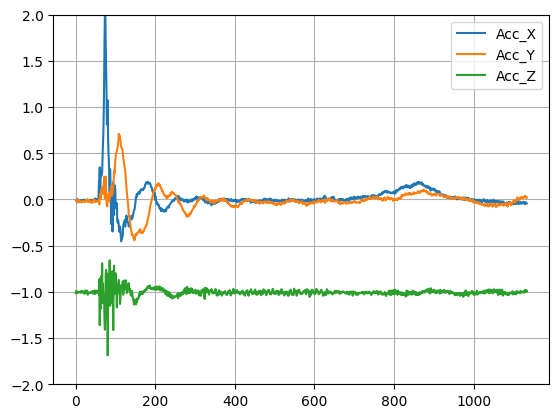

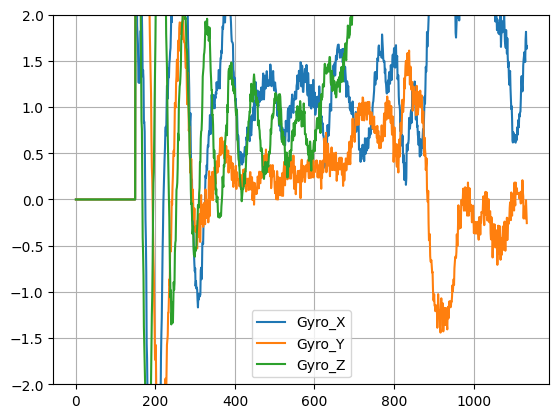

In [87]:
from SignalProcessing import SignalProcessing as sp

gyr_x = data['Sensors'][0]['Data']
gyr_y = (data['Sensors'][1]["Data"])
gyr_z = (data['Sensors'][2]["Data"])
rawData_df = pd.DataFrame(np.array([acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z]).T, columns=["Acc_X","Acc_Y","Acc_Z",'Gyro_X', 'Gyro_Y', 'Gyro_Z'])

acc_signal = sp.rotate_signal(rawData_df, OperationalMat, "FRD", "FLU", ["Acc_X","Acc_Y","Acc_Z"],[0,0,0])
gyro_sig =  sp.rotate_signal(rawData_df, OperationalMat, "FRD", "FLU", ['Gyro_X', 'Gyro_Y', 'Gyro_Z'],[0,0,0])

acc_signal.plot()
plt.grid(True)
plt.ylim([-2,2])
plt.show()

gyro_sig.plot()
plt.grid(True)
plt.ylim([-2,2])
plt.show()



In [88]:
import pandas as pd
import json


# Set total time recorded
total_time_recorded = data['TotalTimeRecorded']

# Create JSON structure
json_data = {
    "Acc_X": {"Data": acc_signal["Acc_X"].tolist()},
    "Acc_Y": {"Data": acc_signal["Acc_Y"].tolist()},
    "Acc_Z": {"Data": acc_signal["Acc_Z"].tolist()},
    "Sensors": [
        {"Data": gyro_sig["Gyro_X"].tolist()},
        {"Data": gyro_sig["Gyro_Y"].tolist()},
        {"Data": gyro_sig["Gyro_Z"].tolist()}
    ],
    "TotalTimeRecorded": total_time_recorded
}

# Save JSON to a file
output_file = "Data\\EV62e5f7c7214dc35247117289.json"
with open(output_file, "w") as file:
    json.dump(json_data, file, indent=4)

print(f"Data saved to {output_file}")


Data saved to Data\EV62e5f7c7214dc35247117289.json
